# Mask R-CNN - Train on Fashion Dataset

This notebook experiments how to train mask r-cnn on fashion dataset.

In [1]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


# Fashion Dataset

In [3]:
from PIL import Image
import numpy
import mimetypes
import hashlib

class FashionDataset(utils.Dataset):
    
    name = "fashion"
    
    # all datasets in one
    classes = {}
    
    def load_dataset(self, dir, expr):
        """
        a data dir contains,
        *.label       class_id : class_label
        *.png         image_id : [r, c, 3] color channels
        *.annotation  image_id : [r, c] mask class labels 
        """
        # add classes
        for root in os.listdir(dir):
            labels_dir = os.path.join(dir, root, '*.label')
            with open(labels_dir) as file:
                for line in file:
                    _, label = line.strip().split('\t')
                    if label in self.classes:
                        class_id = self.classes[label]
                    else:
                        class_id = len(self.classes) # null: 0
                        self.classes[label] = class_id
                    if label != 'null':
                        self.add_class(self.name, class_id, label)
        
        # add images
        for root, dirs, files in os.walk(dir):
            for file in files:
                type, encoding=mimetypes.guess_type(file)
                if type is not None and 'image' in type:
                    if not expr(file): continue
                    self.add_image(
                        self.name, 
                        image_id=len(self.image_ids) + 1,
                        dir=root,
                        path=os.path.join(root, file),
                        annotations=os.path.join(root, re.sub(r'\..*$', '.annotation', file)),
                        reference='{} {}'.format(root, file)
                    )
                    
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID. numpy.ndarray dim [w,h,3]
        """
        image_info=self.image_info[image_id]
        im_frame=Image.open(image_info['path'])
        return numpy.array(im_frame)
        
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID. numpy.ndarray dim [w,h,#]
        """
        image_info=self.image_info[image_id]
        
        classes = {}
        labels_dir = os.path.join(image_info['dir'], '*.label')
        with open(labels_dir) as file:
            for line in file:
                class_id, label = line.strip().split('\t')
                classes[int(class_id)] = self.classes[label]
        
        im_annotation=numpy.loadtxt(image_info['annotations'], dtype=numpy.uint8)

        labels=numpy.unique(im_annotation)
        num_masks=len(labels)
        nrows, ncols=im_annotation.shape
        flags=numpy.zeros(num_masks,dtype=numpy.uint8)
        class_ids=numpy.zeros(num_masks,dtype=numpy.uint8)
        mask=numpy.zeros([nrows, ncols, num_masks], dtype=numpy.uint8)
        
        for i, class_id in enumerate(labels, 0):
            id = classes[class_id]
            if id == 0: continue # non null
            class_ids[i] = id
            mask[:,:,i]=im_annotation==class_id
            flags[i] = 1 if numpy.count_nonzero(mask[:,:,i]) >= 0 else 0
        
        return mask[:,:,flags > 0], class_ids[flags > 0].astype(np.int32)
        
    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about the image 
        that help looking it up or debugging it. Pass if not present in the dataset
        """
        image_info = self.image_info[image_id]
        if image_info['source'] == self.name:
            return image_info['reference']
        else:
            super(self.__class__).image_reference(self, image_id)

In [4]:
f = lambda s : int(hashlib.md5(s.encode('utf-8')).hexdigest(),16) % 10 == 0
g = lambda s : int(hashlib.md5(s.encode('utf-8')).hexdigest(),16) % 10 != 0

dataset_train = FashionDataset()
dataset_train.load_dataset('fashion', g)
dataset_train.prepare()

dataset_val = FashionDataset()
dataset_val.load_dataset('fashion', f)
dataset_val.prepare()

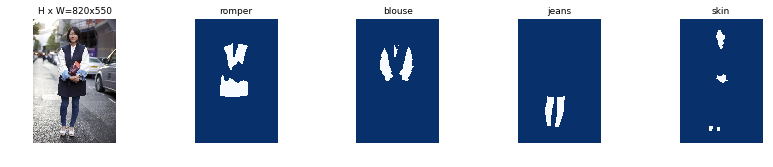

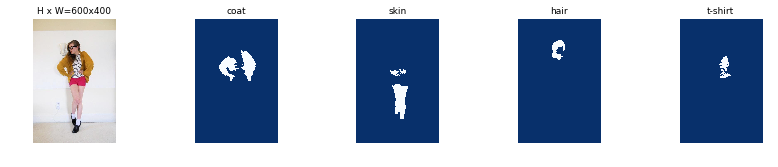

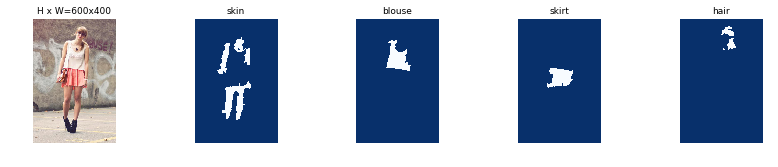

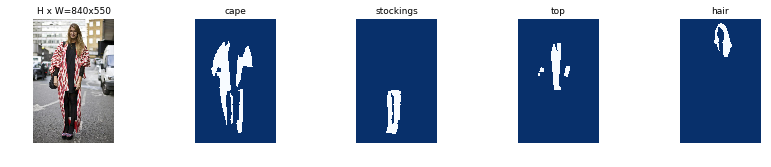

In [5]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Configuration

In [51]:
class FashionConfig(Config):
    NAME = "fashion"
    
    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 59 # TODO
    
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128) # anchor side in pixels
    
    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128
    
    STEPS_PER_EPOCH = 100
    
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    DETECTION_NMS_THRESHOLD = 0.9
    
    DETECTION_MIN_CONFIDENCE = 0.5
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.9
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           fashion
NUM_CLASSES                    60
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRA

In [22]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Build Model

In [8]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [ ]:
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [ ]:
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

# Test Model

In [ ]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [ ]:
model_path = model.find_last()[1]
assert model_path != "", "no model path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

# Debug - Configuration

In [11]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [12]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [52]:
# Override the training configurations for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.9
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           fashion
NUM_CLASSES                    60
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRA

In [31]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Debug - Fashion Dataset

In [32]:
f = lambda s : int(hashlib.md5(s.encode('utf-8')).hexdigest(),16) % 10 == 0

# Build validation dataset
if config.NAME == 'fashion':
    dataset = FashionDataset()
    dataset.load_dataset('fashion', f)
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "minival")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 427
Classes: ['BG', 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit', 'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress', 'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie', 'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace', 'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf', 'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings', 'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie', 'tights', 'top', 'vest', 'wallet', 'watch', 'wedges', 'face']


# Debug - Mask R-CNN Model

In [33]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "fashion":
    weights_path = model.find_last()[1]
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /host/Mask_RCNN/logs/fashion20180130T0604/mask_rcnn_fashion_0010.h5


# Debug - Detection

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


image ID: fashion.1 (340) fashion/tmm_dataset_sharing 32736.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 68)               min:    0.00000  max: 1024.00000


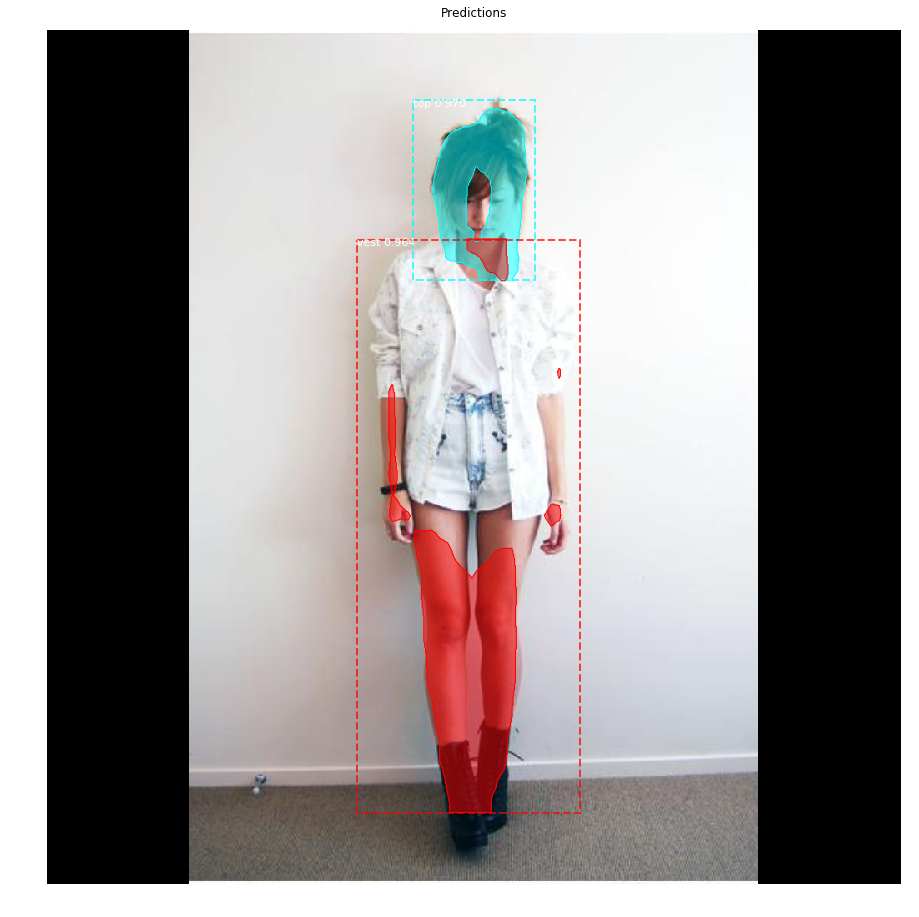

gt_class_id              shape: (7,)                  min:    4.00000  max:   59.00000
gt_bbox                  shape: (7, 4)                min:  112.00000  max:  997.00000
gt_mask                  shape: (1024, 1024, 7)       min:    0.00000  max:    1.00000


In [53]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## 0. Backbone Representation

In [72]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   57.61221
rpn_bbox                 shape: (1, 261888, 4)        min:   -7.47174  max:   66.15063
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


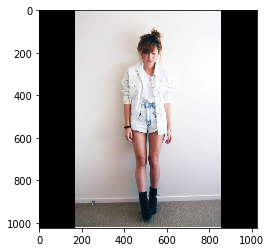

In [73]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

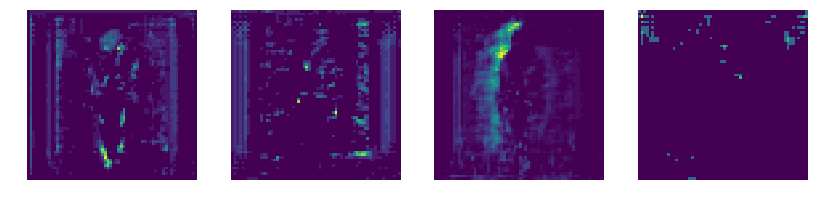

In [74]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

## 1. Region Proposal Network

target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (256, 4)              min:   -4.52990  max:    7.45777
positive_anchors         shape: (7, 4)                min:  128.00000  max:  986.50967
negative_anchors         shape: (249, 4)              min:   -5.65685  max: 1025.65685
neutral anchors          shape: (261632, 4)           min:  -90.50967  max: 1050.50967
refined_anchors          shape: (7, 4)                min:  112.00000  max:  996.99994


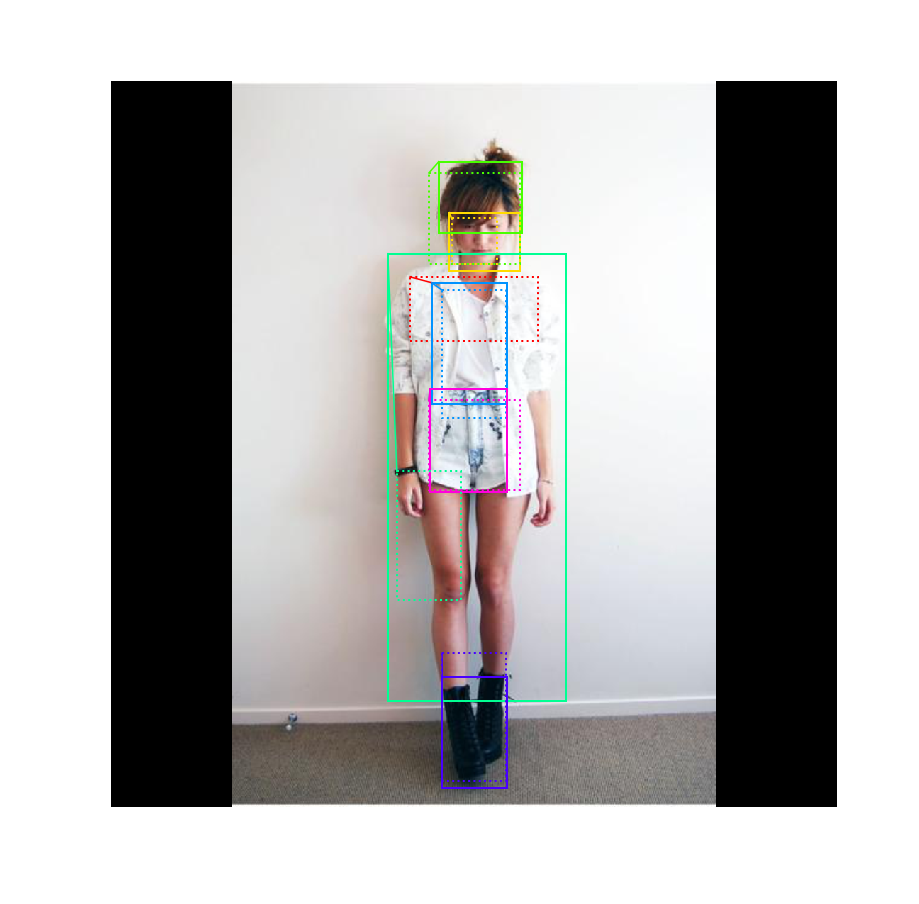

In [54]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 6000, 4)          min:  -90.50967  max: 1050.50964
refined_anchors          shape: (1, 6000, 4)          min: -139632.15625  max: 140514.71875
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max: 1024.00000
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 1891.00000
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


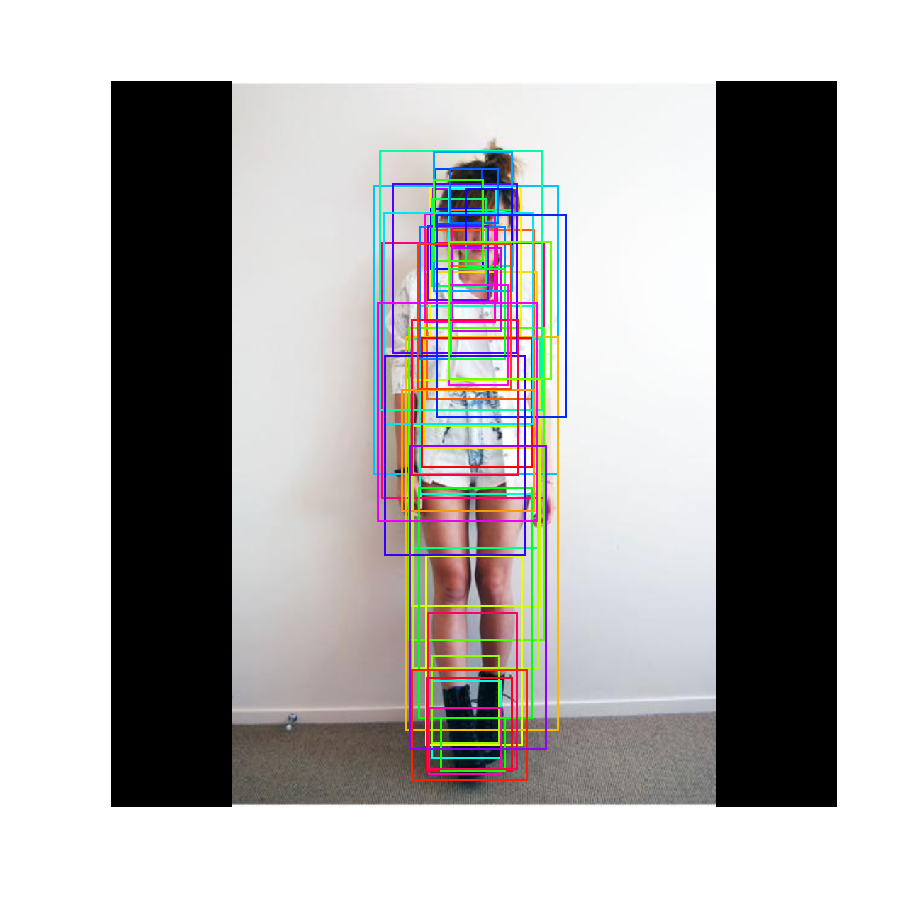

In [55]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

# (refined anchors after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [56]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors (261888)       Recall: 0.429  Positive anchors: 3
Refined Anchors ( 6000)   Recall: 0.857  Positive anchors: 19
Post NMS Anchors (   50)  Recall: 0.143  Positive anchors: 1


## 2. Proposal Classification

In [57]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 60)         min:    0.00000  max:    1.00000
deltas                   shape: (1, 1000, 60, 4)      min:   -5.86345  max:    5.55437
masks                    shape: (1, 100, 28, 28, 60)  min:    0.00001  max:    0.99997
detections               shape: (1, 100, 6)           min:    0.00000  max:  938.00000


In [78]:
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 60)         min:    0.00000  max:    1.00000


array([[[  2.39219218e-01,   8.40571243e-04,   1.25414954e-04, ...,
           1.01223937e-04,   1.78526272e-04,   3.38956388e-03],
        [  8.84249657e-02,   7.12403795e-04,   1.77093199e-03, ...,
           3.31531162e-04,   3.13624070e-04,   2.11598165e-03],
        [  1.09493002e-01,   6.67230051e-04,   1.27630625e-02, ...,
           6.70320762e-04,   4.41072916e-04,   1.73591962e-03],
        ..., 
        [  9.99857187e-01,   4.55470581e-06,   7.35541107e-07, ...,
           7.76864681e-07,   2.51835615e-07,   2.31175954e-06],
        [  9.97936130e-01,   3.03823003e-06,   4.25139433e-06, ...,
           1.53377778e-06,   2.15495379e-06,   1.82315987e-03],
        [  9.87577975e-01,   1.89051952e-05,   1.00222005e-05, ...,
           4.02213209e-06,   4.96911025e-06,   1.12570189e-02]]], dtype=float32)

In [92]:
class_labels = numpy.unique(mrcnn['probs'].argmax(2))
{i:x for i, x in enumerate(dataset_train.class_names, 0)}
# [dataset_train.class_names[c] for c in class_labels]

{0: 'BG',
 1: 'accessories',
 2: 'bag',
 3: 'belt',
 4: 'blazer',
 5: 'blouse',
 6: 'bodysuit',
 7: 'boots',
 8: 'bra',
 9: 'bracelet',
 10: 'cape',
 11: 'cardigan',
 12: 'clogs',
 13: 'coat',
 14: 'dress',
 15: 'earrings',
 16: 'flats',
 17: 'glasses',
 18: 'gloves',
 19: 'hair',
 20: 'hat',
 21: 'heels',
 22: 'hoodie',
 23: 'intimate',
 24: 'jacket',
 25: 'jeans',
 26: 'jumper',
 27: 'leggings',
 28: 'loafers',
 29: 'necklace',
 30: 'panties',
 31: 'pants',
 32: 'pumps',
 33: 'purse',
 34: 'ring',
 35: 'romper',
 36: 'sandals',
 37: 'scarf',
 38: 'shirt',
 39: 'shoes',
 40: 'shorts',
 41: 'skin',
 42: 'skirt',
 43: 'sneakers',
 44: 'socks',
 45: 'stockings',
 46: 'suit',
 47: 'sunglasses',
 48: 'sweater',
 49: 'sweatshirt',
 50: 'swimwear',
 51: 't-shirt',
 52: 'tie',
 53: 'tights',
 54: 'top',
 55: 'vest',
 56: 'wallet',
 57: 'watch',
 58: 'wedges',
 59: 'face'}

2 detections: ['top' 'vest']


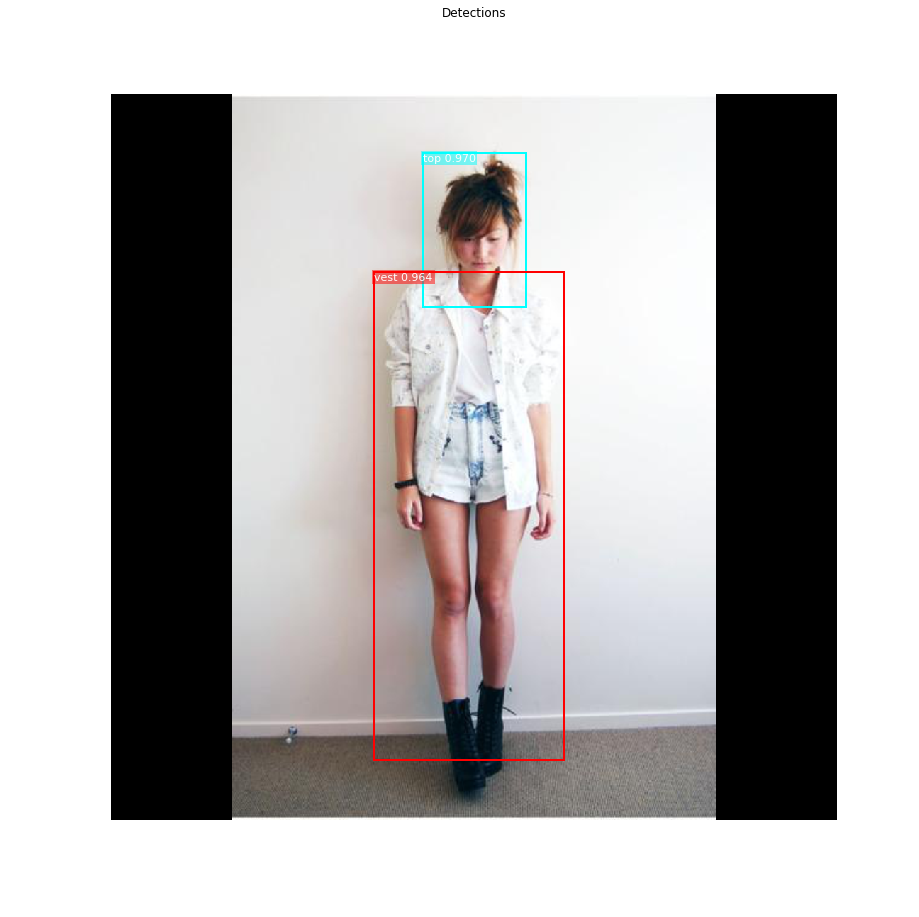

In [58]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=detections[:, :4],
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

In [59]:
 # Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
99 Positive ROIs
[('BG', 901), ('bag', 2), ('blazer', 10), ('bodysuit', 11), ('boots', 1), ('bra', 7), ('cardigan', 5), ('dress', 1), ('gloves', 6), ('top', 33), ('vest', 23)]


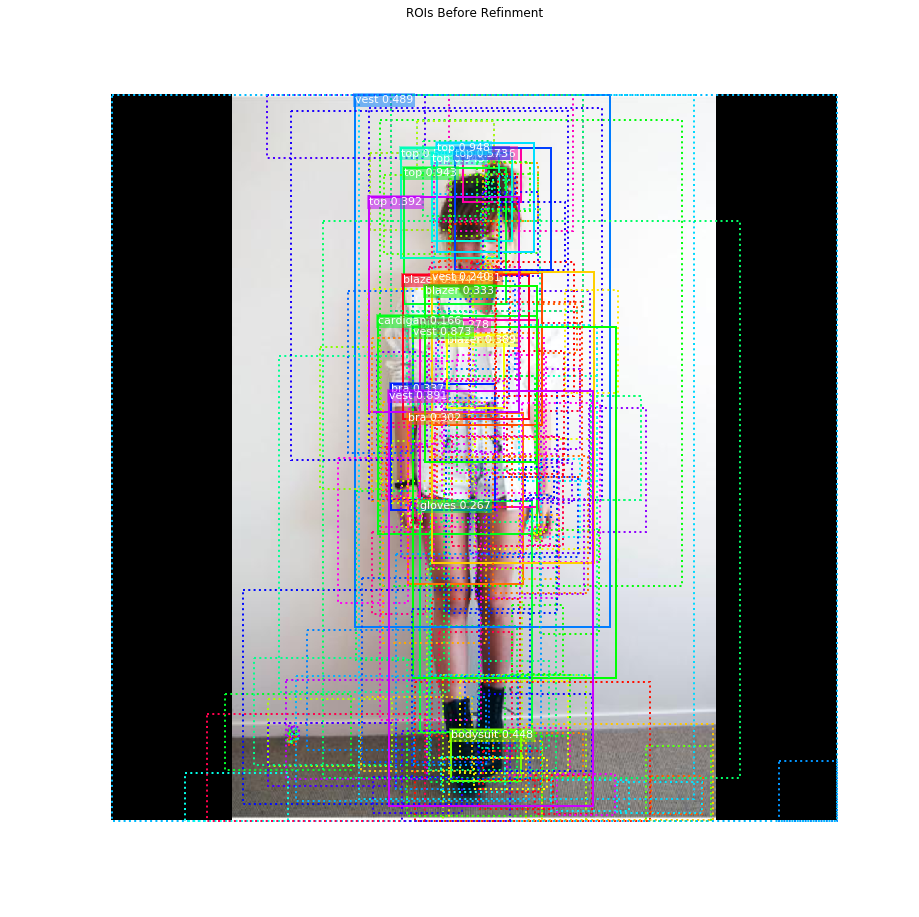

In [60]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinment",
                     ax=get_ax())

roi_bbox_specific        shape: (1000, 4)             min:   -3.84214  max:    3.87515
refined_proposals        shape: (1000, 4)             min: -224.00000  max: 1217.00000


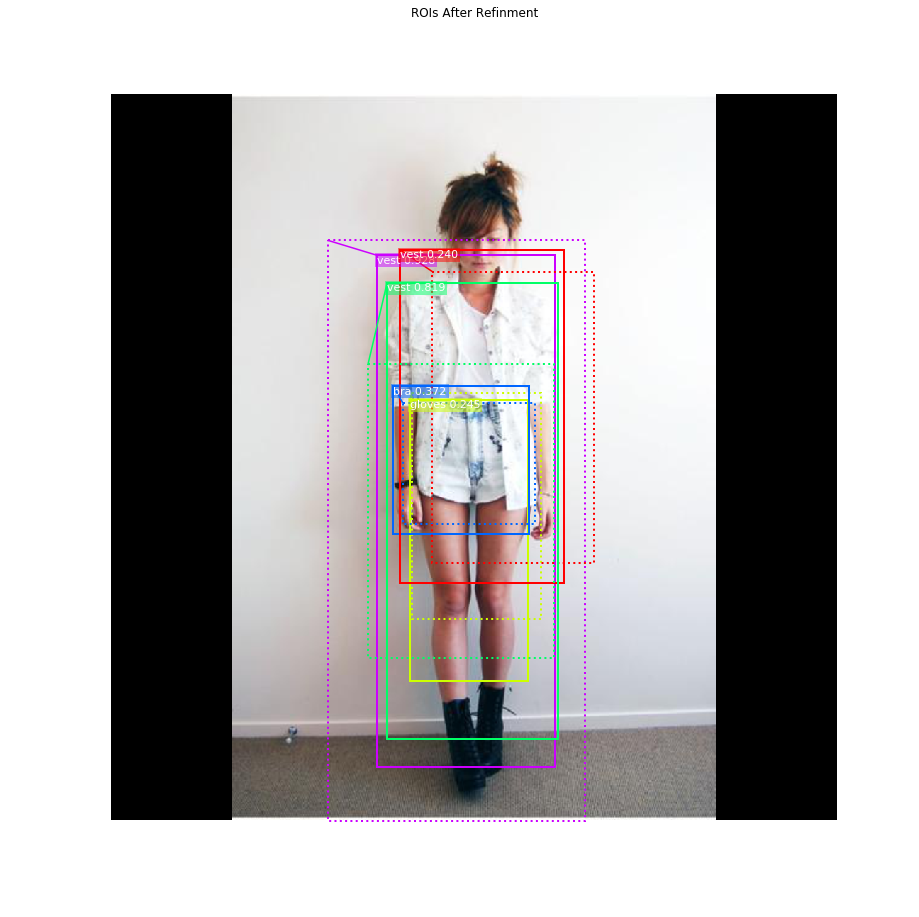

In [61]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinment",
                     ax=get_ax())

In [63]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Keep 99 detections:
[  0   1   2   3   4   5   6   7   9  12  13  14  19  21  25  26  27  28
  29  34  38  41  43  44  47  48  52  55  59  64  66  73  75  76  83  89
  94 105 107 112 124 125 126 130 135 139 142 150 173 174 176 205 206 213
 217 218 226 227 228 243 247 251 255 260 262 263 265 271 272 273 275 279
 288 297 311 315 333 336 349 351 352 378 382 396 404 407 427 445 577 653
 660 671 711 721 765 852 857 873 914]
Remove boxes below 0.5 confidence. Keep 51:
[  3  19  26  27  34  43  64  83  89  94 107 112 124 126 130 135 139 142
 150 174 176 205 206 217 247 262 263 265 271 272 273 275 288 297 311 315
 336 349 351 352 378 382 396 404 407 427 445 721 852 857 914]


In [64]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

bodysuit              : [ 26  43 107 126 176] -> [ 43  26 107 126 176]
top                   : [  3  27  34  64  83  89 112 124 130 135 142 150 174 205 206 217 247 263
 275 288 315 351 382 396 404 407 852 857 914] -> [205 288 135 112  64   3 142 275 382 263 407  27 396 124 857 247  89 404
 852 150  83 130 914 217 351 206 174]
vest                  : [ 19  94 139 262 265 271 272 273 297 311 336 349 352 378 427 445 721] -> [297 262 272 273 311 352 265 721 378]

Kept after per-class NMS: 41
[  3  26  27  43  64  83  89 107 112 124 126 130 135 142 150 174 176 205
 206 217 247 262 263 265 272 273 275 288 297 311 351 352 378 382 396 404
 407 721 852 857 914]


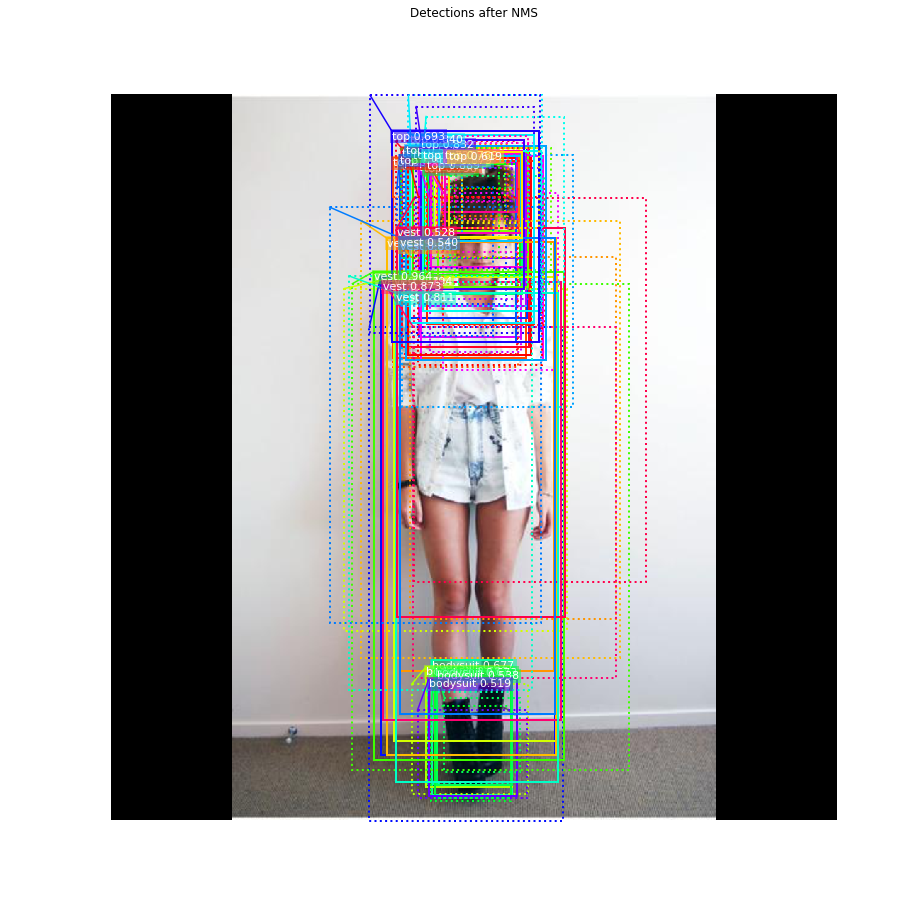

In [65]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## 3. Generating Masks

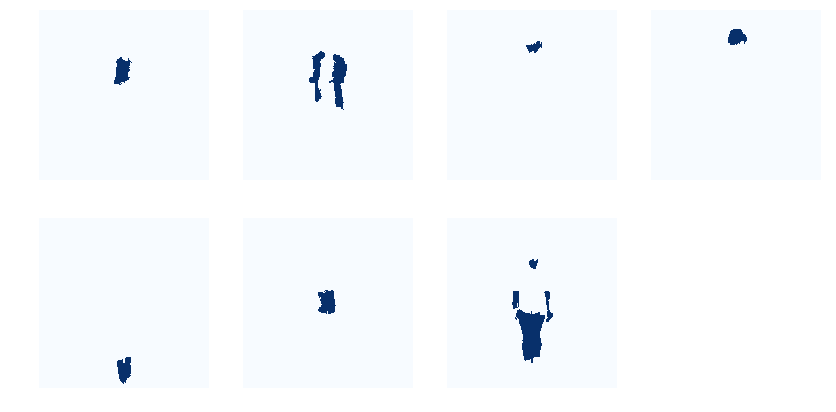

In [66]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

In [67]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:  938.00000
masks                    shape: (1, 100, 28, 28, 60)  min:    0.00001  max:    0.99997
2 detections: ['top' 'vest']


In [68]:
# Masks
det_boxes = mrcnn["detections"][0, :, :4].astype(np.int32)
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (2, 28, 28)           min:    0.00002  max:    0.93323
det_masks                shape: (2, 1024, 1024)       min:    0.00000  max:    1.00000


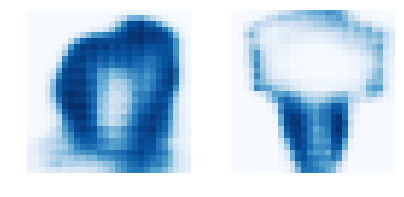

In [69]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

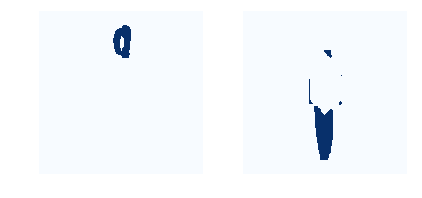

In [70]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")